# Project: Employee Sentiment Analysis  
## Task 1: Sentiment Labeling  
- Using the `test.csv` dataset, leverage a large language model (LLM) to perform sentiment analysis on each message in the dataset. Augment the dataset to contain each message's sentiment label.

### Methodology:

1. **Model Selection:**
   - Initially considered using a Hugging Face model (`cardiffnlp/twitter-roberta-base-sentiment`) due to its simplicity and ability to classify into three categories (positive, negative, neutral). While this model works well for short, informal messages (e.g., tweets), it may not generalize as well to more formal, nuanced employee emails.
   - **Final approach:** Decided to use OpenAI's `gpt-3.5-turbo` via the OpenAI API. This model is more context-aware and better suited for professional communications such as emails, where tone can be subtle or indirect. (~$0.20 cost)

2. **Data Loading & Preparation:**
   - Loaded necessary libraries, modules, and the dataset into a pandas DataFrame.
   - Created a new `message` column by concatenating the `Subject` and `body` columns to form the full message text.

3. **Text Preprocessing:**
   - Removed NaN/empty messages.
   - Ensured text type consistency and limited message length to 512 characters (to reduce token usage and cost).
   - Cleaned the text by removing extra whitespace and URLs.

4. **Sentiment Classification using OpenAI API:**
   - Sent each message individually to the OpenAI API with a clear prompt and system message, asking the model to classify the message as `positive`, `negative`, or `neutral`.
   - Stored the predicted sentiment label in a new column `sentiment` in the DataFrame.

5. **Output:**
   - Exported the resulting labeled dataset to a new CSV file (`openai_sentiment.csv`) for future analysis.


In [9]:
# importing environement, libraries, and our data
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()

import openai 
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

filename = os.path.join(os.getcwd(), 'test(in).csv')
df = pd.read_csv(filename, header = 0)

In [10]:
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [11]:
df.shape

(2191, 4)

In [12]:
# data preprocessing: combining the subject and body columns into a comprehensive message column for analysis
df['message'] = df['Subject'].fillna('') + "\n\n" + df['body'].fillna('')
df.head()

,Subject,body,date,from,message
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update!\n\nEnronOptions Announcem...
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject)\n\nMarc,\n\nUnfortunately, today ..."
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham\n...
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email\n\nwe were thinking papa...
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet\n\nSince you never gave me the $20 for the...


In [13]:
# text preprocessing: removing NaNs/empty messages, ensuring string datatype, trimming long texts, cleaning extra spaces/URLs
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df = df[df['message'].notna()]
df = df[df['message'].str.strip() != '']
df['message'] = df['message'].astype(str)
df['message'] = df['message'].str.slice(0, 512)
df['message'] = df['message'].apply(clean_text)

In [14]:
# using an OpenAI LLM (gpt-3.5-turbo) to perform sentiment analysis on employee messages
client = OpenAI(api_key=api_key)

model = "gpt-3.5-turbo"

sys_msg = "You are a helpful assistant that classifies each employee message as one of three sentiment categories: Positive, Negative, or Neutral. Each message is in the form of an email that contains the subject and body of the email. Your output should just be the label (positive, negative, or neutral)."

def classify_sentiment(message):
    try:
        response = client.chat.completions.create(
            model = model,
            messages = [
                {"role": "system", "content": sys_msg},
                {"role": "user", "content": f"Classify this message as positive, neutral, or negative:\n\n{message}"}
            ],
            temperature=0  # for consistency
        )
        
        sentiment = response.choices[0].message.content.strip().lower()
        return sentiment
    except Exception as e:
        print("Error:", e)
        return "error"

In [15]:
# apply the function on all messages in the dataframe
df['sentiment'] = df['message'].progress_apply(classify_sentiment)
df.head()

100%|██████████| 2191/2191 [15:28<00:00,  2.36it/s]


,Subject,body,date,from,message,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral


/var/folders/zw/c2my0xwx61vb_hm_bj2r3ytr0000gn/T/ipykernel_36171/973560685.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette = 'pastel')


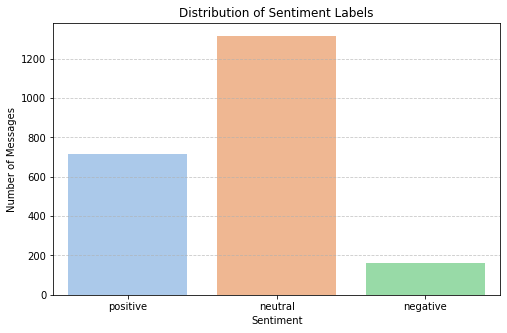

In [26]:
# visualize the distribution of labels
sentiment_counts = df['sentiment'].value_counts().reindex(['positive', 'neutral', 'negative'])

plt.figure(figsize=(8, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette = 'pastel')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Messages')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [17]:
# save the sentiment dataframe to a csv file names openai_sentiment.csv
df.to_csv('openai_sentiment.csv', index = False)

In [19]:
df.shape

(2191, 6)

### Validation Methodology:

1. **Manual Review:**
   - Randomly sampled a subset of messages (e.g., 50 messages).
   - Manually read and labeled the sentiment for each message based on context and tone.
   - Compared manual labels with the model-generated labels to assess alignment and identify discrepancies.

2. **Distribution Analysis:**
   - Visualized the distribution of sentiment classes (`positive`, `neutral`, `negative`) across the entire dataset using a bar chart.
   - Checked for skewness or class imbalance that may suggest overfitting or misclassification by the model.

## Task 2: Exporatory Data Analysis
- Understand the structure, distribution, and trends in the dataset through thorough exploration:

### Methodology:
 - examine overall data structure
 - investigate the distribution of sentiment labels
 - analyze trends over time
 - explore additional patterns or anomalies
 - prepare visualizations

In [21]:
# use the openai_sentiment.csv as our new dataframe for future analysis
sentiment_filename = os.path.join(os.getcwd(), 'openai_sentiment.csv')
sentiment_df = pd.read_csv(sentiment_filename, header = 0)
sentiment_df.head()

,Subject,body,date,from,message,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral


In [27]:
# 1. examining overall structure of the dataframe:
# missing values
sentiment_df.isnull().any()

Subject      False
body         False
date         False
from         False
message      False
sentiment    False
dtype: bool

In [28]:
# examine the dimensions of the dataframe (rows, columns)
sentiment_df.shape

(2191, 6)

In [29]:
# summary statistics of the dataframe
sentiment_df.describe()

,Subject,body,date,from,message,sentiment
count,2191,2191,2191,2191,2191,2191
unique,1251,1539,690,10,1534,3
top,(No Subject),\n\n,7/1/2011,lydia.delgado@enron.com,(No Subject),neutral
freq,141,21,9,284,27,1315


Findings from the summary statistics:
- Total emails: 2,191
- Most common subject: “(No Subject)” (141 times)
- Most frequent sender: [lydia.delgado@enron.com](mailto:lydia.delgado@enron.com) (284 emails)
- Most emails sent on: 7/1/2011 (9 emails)
- Most common sentiment: *Neutral* (1,315 emails, \~60%)
- Frequent message content: Many are empty or repeated
- Unique senders: Only 10 employees in total

In [30]:
# data types of columns in the dataframe
sentiment_df.dtypes

Subject      object
body         object
date         object
from         object
message      object
sentiment    object
dtype: object

In [31]:
sentiment_df['sentiment'].value_counts(normalize=True)

sentiment
neutral     0.600183
positive    0.326791
negative    0.073026
Name: proportion, dtype: float64

Sentiment Distribution:
- Neutral: 60.0% of all messages
- Positive: 32.7% of all messages
- Negative: 7.3%% of all messages

<Axes: xlabel='date'>

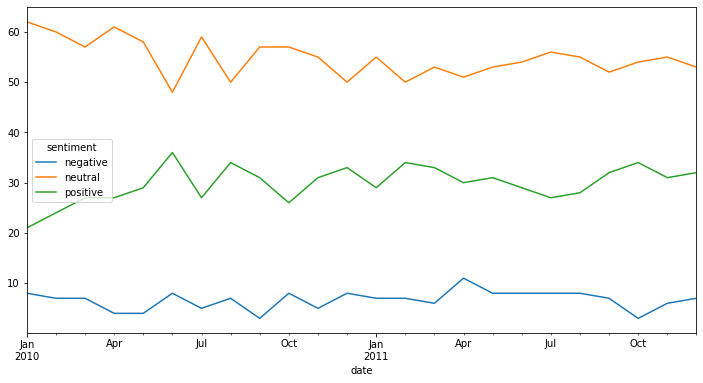

In [39]:
monthly_sentiment = (
    sentiment_df
    .groupby(sentiment_df['date'].dt.to_period("M"))['sentiment']
    .value_counts()
    .unstack()
)
monthly_sentiment.index = monthly_sentiment.index.to_timestamp()
monthly_sentiment.plot(kind='line', figsize=(12,6))

- Neutral Sentiment dominates throughout the year ranging for 50-68 messages per month.
- Positive Sentiment follows next with an upward trend overall, starts around 20 per month and ends ~30 messages per month.
- Negative sentiment is consistently low rarely exceeding 10 messages per month, but occasionally spikes (June/April).

In [34]:
# exploring additional patters:
# 1. sentiment by sender: see if some senders are consistenly more positive/negative/neutral
sentiment_df.groupby('from')['sentiment'].value_counts(normalize=True).unstack().sort_values('negative', ascending=False).head(10)

sentiment,negative,neutral,positive
from,,,
kayne.coulter@enron.com,0.097701,0.557471,0.344828
john.arnold@enron.com,0.085938,0.585938,0.328125
sally.beck@enron.com,0.083700,0.581498,0.334802
rhonda.denton@enron.com,0.081395,0.622093,0.296512
patti.thompson@enron.com,0.075556,0.595556,0.328889
johnny.palmer@enron.com,0.075117,0.553991,0.370892
don.baughman@enron.com,0.070423,0.680751,0.248826
bobette.riner@ipgdirect.com,0.069124,0.585253,0.345622
lydia.delgado@enron.com,0.052817,0.626761,0.320423


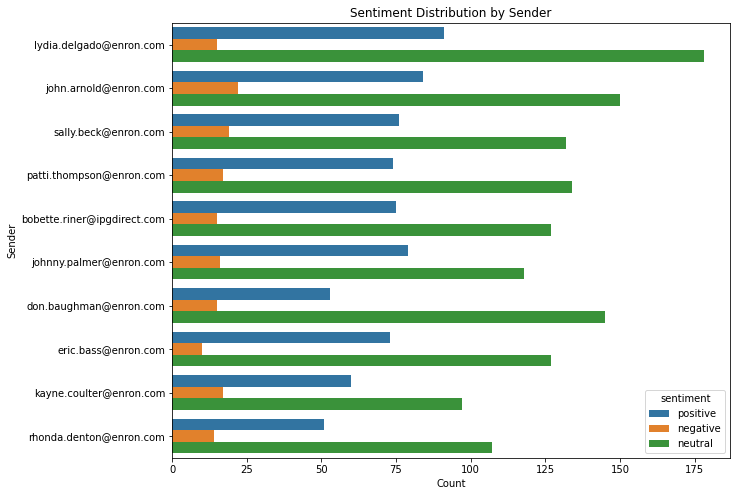

In [38]:
# Visualize previous cell:
plt.figure(figsize=(10, 8))
sns.countplot(data=sentiment_df, y='from', hue='sentiment', order=sentiment_df['from'].value_counts().index)
plt.title("Sentiment Distribution by Sender")
plt.xlabel("Count")
plt.ylabel("Sender")
plt.show()

- Kayne Coulter and Bobette Riner have the highest proportions of negative messages (~9%), suggesting they may express more dissatisfaction or concern in communication.

- Eric Bass shows the lowest negative sentiment (~3.8%) and a relatively high positive rate (~30%), indicating a more upbeat communication tone.

- Overall, most top senders still have neutral as their dominant sentiment, with varying levels of positive and negative tone.

- This pattern may suggest personality-driven or role-based differences in communication style across employees.

In [36]:
# get the most common subject lines for each sentiment
top_subjects_by_sentiment = (
    sentiment_df.groupby('sentiment')['Subject']
    .value_counts()
    .groupby(level=0)
    .head(5)
    .reset_index(name='count')
)

top_subjects_by_sentiment

,sentiment,Subject,count
0,negative,(No Subject),16
1,negative,Re:,12
2,negative,Flat books,3
3,negative,MISO proposed $1000 penalty,3
4,negative,Re: Davis,3
5,neutral,(No Subject),96
6,neutral,Re:,45
7,neutral,RE:,14
8,neutral,Interview Schedule,9
9,neutral,Master Power Contracts,8


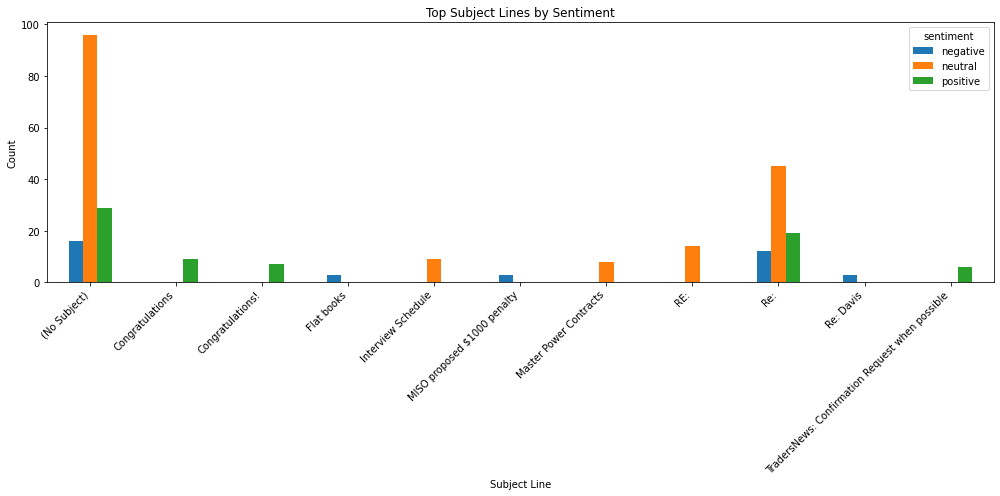

In [37]:
# visualizing previous cell
top_subjects_pivot = top_subjects_by_sentiment.pivot_table(
    index='Subject', columns='sentiment', values='count', fill_value=0
)

top_subjects_pivot.plot(kind='bar', figsize=(14, 7))
plt.title('Top Subject Lines by Sentiment')
plt.xlabel('Subject Line')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- "(No Subject)" and "Re:" are the most common across all sentiments, indicating a prevalence of reply chains or undeclared topics in emails.

- Negative Sentiment:
Common subjects relate to issues or absences, e.g., “MISO proposed $1000 penalty” and “Out of the Office.”

- Neutral Sentiment:
Dominated by routine or procedural topics, like “Interview Schedule” and “Master Power Contracts.”

- Positive Sentiment:
Includes more congratulatory or celebratory messages like “Congratulations” and “Bearkadette Schedule.”

## Task 3: Employee Score Calculation

In this step, we computed a **monthly sentiment score** for each employee based on their messages.

### Scoring Rules:
- **Positive message**: +1
- **Neutral message**: 0
- **Negative message**: -1

### Methodology:
1. **Sentiment Mapping**: Mapped each message’s sentiment label to a numeric score using a dictionary.
2. **Date Parsing**: Ensured the `date` column was in datetime format and extracted the month.
3. **Monthly Aggregation**: Grouped data by `employee_email` and `month`, then summed sentiment scores.
4. **Result Inspection**: Produced a table showing the sentiment score per employee for each month.

This score gives a simple but interpretable view of each employee's emotional tone over time and sets the stage for further analysis.


In [40]:
# observe the number of employees (from senders) in the data
# 10 employees in the dataset
sentiment_df['from'].nunique()

10

In [41]:
# Map sentiment labels to scores
score_map = {
    'positive': 1,
    'neutral': 0,
    'negative': -1
}

sentiment_df['sentiment_score'] = sentiment_df['sentiment'].map(score_map)
sentiment_df.head()

,Subject,body,date,from,message,sentiment,sentiment_score
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive,1
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative,-1
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral,0
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral,0
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral,0


In [42]:
# ensure date column is datetime
sentiment_df['date_parsed'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

# extract month and year for grouping
sentiment_df['month'] = sentiment_df['date_parsed'].dt.to_period('M')


In [43]:
# group by sender and month, then sum sentiment scores
monthly_scores = sentiment_df.groupby(['from', 'month'])['sentiment_score'].sum().reset_index()

# renaming columns for better clarity
monthly_scores.columns = ['employee_email', 'month', 'monthly_sentiment_score']
monthly_scores.head()


,employee_email,month,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,0
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,3
3,bobette.riner@ipgdirect.com,2010-04,2
4,bobette.riner@ipgdirect.com,2010-05,2


In [44]:
# sorting our dataframe by month and employee + viewing results
display(monthly_scores.sort_values(by=['employee_email', 'month']))

,employee_email,month,monthly_sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,0
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,3
3,bobette.riner@ipgdirect.com,2010-04,2
4,bobette.riner@ipgdirect.com,2010-05,2
...,...,...,...
235,sally.beck@enron.com,2011-08,0
236,sally.beck@enron.com,2011-09,0
237,sally.beck@enron.com,2011-10,4
238,sally.beck@enron.com,2011-11,1


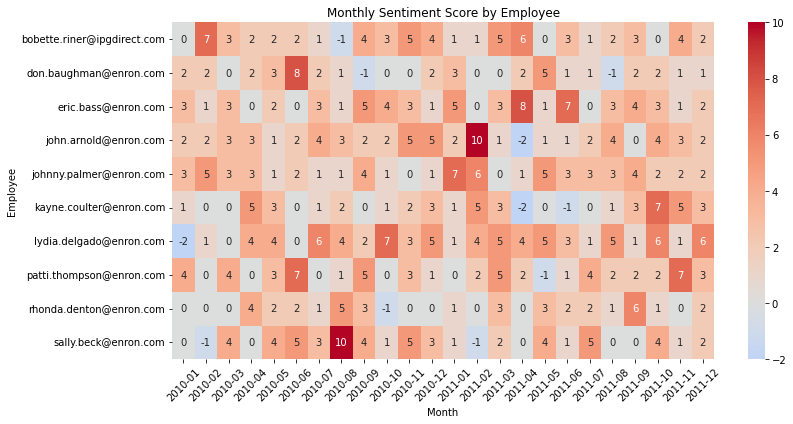

In [46]:
# heatmap of scores across employees/months.
score_pivot = monthly_scores.pivot(index='employee_email', columns='month', values='monthly_sentiment_score').fillna(0)
plt.figure(figsize=(12, 6))
sns.heatmap(score_pivot, annot=True, fmt='g', cmap='coolwarm', center=0)
plt.title("Monthly Sentiment Score by Employee")
plt.ylabel("Employee")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**explain the heatmap above here**

## Task 4: Employee Ranking

In this task, we generated rankings of employees based on their **monthly sentiment scores** to identify top performers and potential issues in communication tone.

### Objectives:
- Rank employees each month by sentiment score.
  - **Top 3 Positive**: Employees with the highest scores.
  - **Top 3 Negative**: Employees with the lowest (most negative) scores.
- Compute **overall rankings** by aggregating scores across all months.

### Methodology:
1. **Ranking Function**: Defined a reusable function that sorts employee sentiment scores and extracts the top 3 positive and top 3 negative employees.
2. **Monthly Rankings**: Applied this function for each month using `groupby().apply()`.
3. **Overall Rankings**: Aggregated sentiment scores across all months, sorted, and extracted top/bottom 3 employees.
4. **Presentation**:
   - Rankings were displayed in tables.
   - A **bar plot** visualized monthly top positive and negative employees.

This step helps identify positive communicators but also employees whose message tone may need attention.


In [47]:
def rank_monthly_employees(df):
    # for each month, get top 3 positive and top 3 negative
    top_positive = df.sort_values(
        by=['monthly_sentiment_score', 'employee_email'],
        ascending=[False, True]
    ).head(3)
    top_positive['rank_type'] = 'Top Positive'

    top_negative = df.sort_values(
        by=['monthly_sentiment_score', 'employee_email'],
        ascending=[True, True]
    ).head(3)
    top_negative['rank_type'] = 'Top Negative'

    return pd.concat([top_positive, top_negative])

In [48]:
# apply the ranking function to each month's data
ranked_df = (
    monthly_scores
    .groupby('month')
    .apply(rank_monthly_employees)
    .reset_index(drop=True)
)

In [52]:
# display the monthly rankings
for month in ranked_df['month'].unique():
    print(f"\n Rankings for {month}")
    display(ranked_df[ranked_df['month'] == month][['rank_type', 'employee_email', 'monthly_sentiment_score']])


 Rankings for 2010-01


,rank_type,employee_email,monthly_sentiment_score
0,Top Positive,patti.thompson@enron.com,4
1,Top Positive,eric.bass@enron.com,3
2,Top Positive,johnny.palmer@enron.com,3
3,Top Negative,lydia.delgado@enron.com,-2
4,Top Negative,bobette.riner@ipgdirect.com,0
5,Top Negative,rhonda.denton@enron.com,0



 Rankings for 2010-02


,rank_type,employee_email,monthly_sentiment_score
6,Top Positive,bobette.riner@ipgdirect.com,7
7,Top Positive,johnny.palmer@enron.com,5
8,Top Positive,don.baughman@enron.com,2
9,Top Negative,sally.beck@enron.com,-1
10,Top Negative,kayne.coulter@enron.com,0
11,Top Negative,patti.thompson@enron.com,0



 Rankings for 2010-03


,rank_type,employee_email,monthly_sentiment_score
12,Top Positive,patti.thompson@enron.com,4
13,Top Positive,sally.beck@enron.com,4
14,Top Positive,bobette.riner@ipgdirect.com,3
15,Top Negative,don.baughman@enron.com,0
16,Top Negative,kayne.coulter@enron.com,0
17,Top Negative,lydia.delgado@enron.com,0



 Rankings for 2010-04


,rank_type,employee_email,monthly_sentiment_score
18,Top Positive,kayne.coulter@enron.com,5
19,Top Positive,lydia.delgado@enron.com,4
20,Top Positive,rhonda.denton@enron.com,4
21,Top Negative,eric.bass@enron.com,0
22,Top Negative,patti.thompson@enron.com,0
23,Top Negative,sally.beck@enron.com,0



 Rankings for 2010-05


,rank_type,employee_email,monthly_sentiment_score
24,Top Positive,lydia.delgado@enron.com,4
25,Top Positive,sally.beck@enron.com,4
26,Top Positive,don.baughman@enron.com,3
27,Top Negative,john.arnold@enron.com,1
28,Top Negative,johnny.palmer@enron.com,1
29,Top Negative,bobette.riner@ipgdirect.com,2



 Rankings for 2010-06


,rank_type,employee_email,monthly_sentiment_score
30,Top Positive,don.baughman@enron.com,8
31,Top Positive,patti.thompson@enron.com,7
32,Top Positive,sally.beck@enron.com,5
33,Top Negative,eric.bass@enron.com,0
34,Top Negative,kayne.coulter@enron.com,0
35,Top Negative,lydia.delgado@enron.com,0



 Rankings for 2010-07


,rank_type,employee_email,monthly_sentiment_score
36,Top Positive,lydia.delgado@enron.com,6
37,Top Positive,john.arnold@enron.com,4
38,Top Positive,eric.bass@enron.com,3
39,Top Negative,patti.thompson@enron.com,0
40,Top Negative,bobette.riner@ipgdirect.com,1
41,Top Negative,johnny.palmer@enron.com,1



 Rankings for 2010-08


,rank_type,employee_email,monthly_sentiment_score
42,Top Positive,sally.beck@enron.com,10
43,Top Positive,rhonda.denton@enron.com,5
44,Top Positive,lydia.delgado@enron.com,4
45,Top Negative,bobette.riner@ipgdirect.com,-1
46,Top Negative,don.baughman@enron.com,1
47,Top Negative,eric.bass@enron.com,1



 Rankings for 2010-09


,rank_type,employee_email,monthly_sentiment_score
48,Top Positive,eric.bass@enron.com,5
49,Top Positive,patti.thompson@enron.com,5
50,Top Positive,bobette.riner@ipgdirect.com,4
51,Top Negative,don.baughman@enron.com,-1
52,Top Negative,kayne.coulter@enron.com,0
53,Top Negative,john.arnold@enron.com,2



 Rankings for 2010-10


,rank_type,employee_email,monthly_sentiment_score
54,Top Positive,lydia.delgado@enron.com,7
55,Top Positive,eric.bass@enron.com,4
56,Top Positive,bobette.riner@ipgdirect.com,3
57,Top Negative,rhonda.denton@enron.com,-1
58,Top Negative,don.baughman@enron.com,0
59,Top Negative,patti.thompson@enron.com,0



 Rankings for 2010-11


,rank_type,employee_email,monthly_sentiment_score
60,Top Positive,bobette.riner@ipgdirect.com,5
61,Top Positive,john.arnold@enron.com,5
62,Top Positive,sally.beck@enron.com,5
63,Top Negative,don.baughman@enron.com,0
64,Top Negative,johnny.palmer@enron.com,0
65,Top Negative,rhonda.denton@enron.com,0



 Rankings for 2010-12


,rank_type,employee_email,monthly_sentiment_score
66,Top Positive,john.arnold@enron.com,5
67,Top Positive,lydia.delgado@enron.com,5
68,Top Positive,bobette.riner@ipgdirect.com,4
69,Top Negative,rhonda.denton@enron.com,0
70,Top Negative,eric.bass@enron.com,1
71,Top Negative,johnny.palmer@enron.com,1



 Rankings for 2011-01


,rank_type,employee_email,monthly_sentiment_score
72,Top Positive,johnny.palmer@enron.com,7
73,Top Positive,eric.bass@enron.com,5
74,Top Positive,don.baughman@enron.com,3
75,Top Negative,patti.thompson@enron.com,0
76,Top Negative,bobette.riner@ipgdirect.com,1
77,Top Negative,kayne.coulter@enron.com,1



 Rankings for 2011-02


,rank_type,employee_email,monthly_sentiment_score
78,Top Positive,john.arnold@enron.com,10
79,Top Positive,johnny.palmer@enron.com,6
80,Top Positive,kayne.coulter@enron.com,5
81,Top Negative,sally.beck@enron.com,-1
82,Top Negative,don.baughman@enron.com,0
83,Top Negative,eric.bass@enron.com,0



 Rankings for 2011-03


,rank_type,employee_email,monthly_sentiment_score
84,Top Positive,bobette.riner@ipgdirect.com,5
85,Top Positive,lydia.delgado@enron.com,5
86,Top Positive,patti.thompson@enron.com,5
87,Top Negative,don.baughman@enron.com,0
88,Top Negative,johnny.palmer@enron.com,0
89,Top Negative,john.arnold@enron.com,1



 Rankings for 2011-04


,rank_type,employee_email,monthly_sentiment_score
90,Top Positive,eric.bass@enron.com,8
91,Top Positive,bobette.riner@ipgdirect.com,6
92,Top Positive,lydia.delgado@enron.com,4
93,Top Negative,john.arnold@enron.com,-2
94,Top Negative,kayne.coulter@enron.com,-2
95,Top Negative,rhonda.denton@enron.com,0



 Rankings for 2011-05


,rank_type,employee_email,monthly_sentiment_score
96,Top Positive,don.baughman@enron.com,5
97,Top Positive,johnny.palmer@enron.com,5
98,Top Positive,lydia.delgado@enron.com,5
99,Top Negative,patti.thompson@enron.com,-1
100,Top Negative,bobette.riner@ipgdirect.com,0
101,Top Negative,kayne.coulter@enron.com,0



 Rankings for 2011-06


,rank_type,employee_email,monthly_sentiment_score
102,Top Positive,eric.bass@enron.com,7
103,Top Positive,bobette.riner@ipgdirect.com,3
104,Top Positive,johnny.palmer@enron.com,3
105,Top Negative,kayne.coulter@enron.com,-1
106,Top Negative,don.baughman@enron.com,1
107,Top Negative,john.arnold@enron.com,1



 Rankings for 2011-07


,rank_type,employee_email,monthly_sentiment_score
108,Top Positive,sally.beck@enron.com,5
109,Top Positive,patti.thompson@enron.com,4
110,Top Positive,johnny.palmer@enron.com,3
111,Top Negative,eric.bass@enron.com,0
112,Top Negative,kayne.coulter@enron.com,0
113,Top Negative,bobette.riner@ipgdirect.com,1



 Rankings for 2011-08


,rank_type,employee_email,monthly_sentiment_score
114,Top Positive,lydia.delgado@enron.com,5
115,Top Positive,john.arnold@enron.com,4
116,Top Positive,eric.bass@enron.com,3
117,Top Negative,don.baughman@enron.com,-1
118,Top Negative,sally.beck@enron.com,0
119,Top Negative,kayne.coulter@enron.com,1



 Rankings for 2011-09


,rank_type,employee_email,monthly_sentiment_score
120,Top Positive,rhonda.denton@enron.com,6
121,Top Positive,eric.bass@enron.com,4
122,Top Positive,johnny.palmer@enron.com,4
123,Top Negative,john.arnold@enron.com,0
124,Top Negative,sally.beck@enron.com,0
125,Top Negative,lydia.delgado@enron.com,1



 Rankings for 2011-10


,rank_type,employee_email,monthly_sentiment_score
126,Top Positive,kayne.coulter@enron.com,7
127,Top Positive,lydia.delgado@enron.com,6
128,Top Positive,john.arnold@enron.com,4
129,Top Negative,bobette.riner@ipgdirect.com,0
130,Top Negative,rhonda.denton@enron.com,1
131,Top Negative,don.baughman@enron.com,2



 Rankings for 2011-11


,rank_type,employee_email,monthly_sentiment_score
132,Top Positive,patti.thompson@enron.com,7
133,Top Positive,kayne.coulter@enron.com,5
134,Top Positive,bobette.riner@ipgdirect.com,4
135,Top Negative,rhonda.denton@enron.com,0
136,Top Negative,don.baughman@enron.com,1
137,Top Negative,eric.bass@enron.com,1



 Rankings for 2011-12


,rank_type,employee_email,monthly_sentiment_score
138,Top Positive,lydia.delgado@enron.com,6
139,Top Positive,kayne.coulter@enron.com,3
140,Top Positive,patti.thompson@enron.com,3
141,Top Negative,don.baughman@enron.com,1
142,Top Negative,bobette.riner@ipgdirect.com,2
143,Top Negative,eric.bass@enron.com,2


In [ ]:
# aggregate sentiment scores across all months
overall_scores = (
    monthly_scores
    .groupby('employee_email')['monthly_sentiment_score']
    .sum()
    .reset_index()
)

# top 3 positive employees
top_overall_positive = (
    overall_scores
    .sort_values(by='monthly_sentiment_score', ascending=False)
    .head(3)
)
top_overall_positive['rank_type'] = 'Top Positive'

# top 3 negative employees
top_overall_negative = (
    overall_scores
    .sort_values(by='monthly_sentiment_score', ascending=True)
    .head(3)
)
top_overall_negative['rank_type'] = 'Top Negative'

# combine + display
top_employees_overall = pd.concat([top_overall_positive, top_overall_negative])

print("🏅 Overall Top Positive and Negative Employees")
display(top_employees_overall[['rank_type', 'employee_email', 'monthly_sentiment_score']])


🏅 Overall Top Positive and Negative Employees


,rank_type,employee_email,monthly_sentiment_score
6,Top Positive,lydia.delgado@enron.com,76
2,Top Positive,eric.bass@enron.com,63
4,Top Positive,johnny.palmer@enron.com,63
8,Top Negative,rhonda.denton@enron.com,37
1,Top Negative,don.baughman@enron.com,38
5,Top Negative,kayne.coulter@enron.com,43


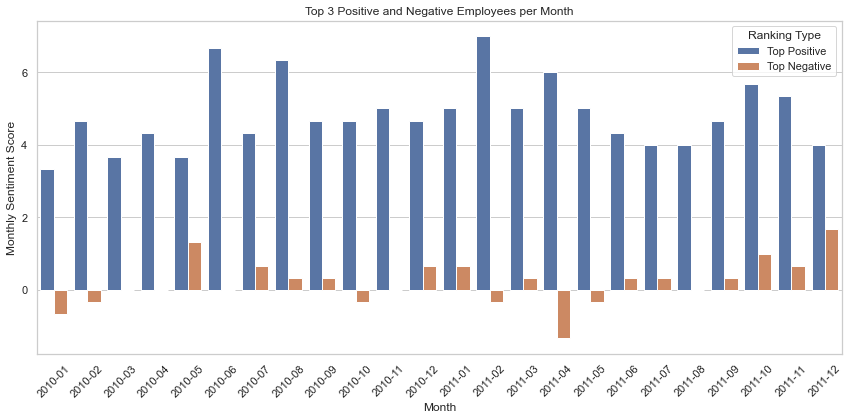

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'month' to string for better x-axis labels
ranked_df['month'] = ranked_df['month'].astype(str)

# Set plot style
sns.set(style="whitegrid")

# Create barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=ranked_df,
    x='month',
    y='monthly_sentiment_score',
    hue='rank_type',
    errorbar = None
)

plt.title('Top 3 Positive and Negative Employees per Month')
plt.ylabel('Monthly Sentiment Score')
plt.xlabel('Month')
plt.legend(title='Ranking Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Top Positive sentiment scores are consistently high, typically between 3 and 7, indicating strong positive communication across months.

- Top Negative scores are low in magnitude, often just -1 to -2, suggesting limited extreme negativity even among the most negative employees.

- Peak positivity occurred in May 2010, January 2011, and March 2011, with sentiment scores above 6.

- Notable spikes in negativity appear in April 2011 and December 2011, possibly signaling workplace tension or dissatisfaction during those periods.

- Consistent trends in top communicators suggest reliable patterns in employee sentiment, useful for monitoring morale and engagement.

## Task 5: Flight Risk Identification

In this task, we identified **employees at risk of leaving the organization**, termed *flight risks*, based on their communication patterns.

### Objective:
Flag employees who sent **4 or more negative messages within any 30-day period**, regardless of calendar months.

### Methodology:
1. **Filter**:
   - Retained only emails labeled as `negative`.

2. **Sort**:
   - Sorted emails by `sender` and `date`.

3. **Check for Rolling Window**:
   - For each employee:
     - Checked all rolling 30-day windows.
     - Flagged if 4 or more negative messages were sent in any such window.

4. **Create Output**:
   - Generated a list of `employee_email`s flagged as flight risks.
   - Stored them in a new dataframe with a boolean `flight_risk` flag.

5. **Visualize**:
   - Plotted a **timeline**

In [53]:
# filter negative messages only
neg_df = sentiment_df[sentiment_df['sentiment'] == 'negative'].copy()

# sort by sender and date
neg_df = neg_df.sort_values(['from', 'date'])
neg_df['date'] = pd.to_datetime(neg_df['date'])

# initialize a set
flight_risk_employees = set()
neg_df.head()

,Subject,body,date,from,message,sentiment,sentiment_score,date_parsed,month
1012,ERMS Resources,I heard today that Curtis Smith has resigned. ...,2010-07-23,bobette.riner@ipgdirect.com,ERMS Resources I heard today that Curtis Smith...,negative,-1,2010-07-23,2010-07
1844,"NOTIFICATION: Outlook Outage - Monday, Januar...",\nThis is a notice to inform you that your mai...,2010-08-11,bobette.riner@ipgdirect.com,"NOTIFICATION: Outlook Outage - Monday, January...",negative,-1,2010-08-11,2010-08
1787,Re: Practice,i expected a better reply from you\n\n\n\n\nBr...,2010-08-14,bobette.riner@ipgdirect.com,Re: Practice i expected a better reply from yo...,negative,-1,2010-08-14,2010-08
1448,Ken Lay Resigns from Board,Ken Lay announced today that he has resigned f...,2010-08-23,bobette.riner@ipgdirect.com,Ken Lay Resigns from Board Ken Lay announced t...,negative,-1,2010-08-23,2010-08
1035,Re: CWS,I don't need to talk shit about the game. I w...,2010-11-02,bobette.riner@ipgdirect.com,Re: CWS I don't need to talk shit about the ga...,negative,-1,2010-11-02,2010-11


In [54]:
# check rolling 30-day window for each employee
for sender, group in neg_df.groupby('from'):
    dates = group['date'].reset_index(drop=True)
    for i in range(len(dates)):
        window = dates[(dates >= dates[i]) & (dates <= dates[i] + pd.Timedelta(days=30))]
        if len(window) >= 4:
            flight_risk_employees.add(sender)
            break

In [55]:
# creating a new flight_risk_df of our results:
flight_risk_df = pd.DataFrame({'employee_email': list(flight_risk_employees)})
flight_risk_df['flight_risk'] = True

print("Employees flagged as flight risks:")
display(flight_risk_df)

Employees flagged as flight risks:


,employee_email,flight_risk
0,don.baughman@enron.com,True
1,john.arnold@enron.com,True


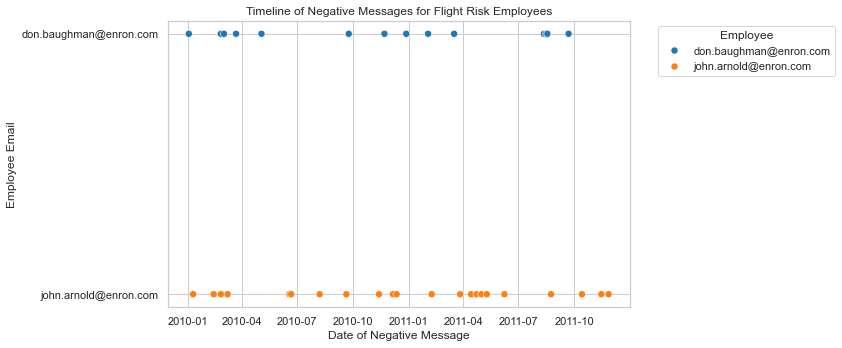

In [60]:
# Filter just the flight risk employees
risk_emails = flight_risk_employees
plot_df = neg_df[neg_df['from'].isin(risk_emails)]

plt.figure(figsize=(12, 5))
sns.scatterplot(data=plot_df, x='date', y='from', hue='from', palette='tab10', s=50)

plt.title("Timeline of Negative Messages for Flight Risk Employees")
plt.xlabel("Date of Negative Message")
plt.ylabel("Employee Email")
plt.legend(title='Employee', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

•	Clusters of points close together horizontally (same employee): This suggests the employee sent multiple negative messages in a short period (ikely why they were flagged as flight risks).

•	Long gaps between messages: Could indicate cooling off or recovery in sentiment.

•	High density in a short time: May correlate with acute stress, conflict, or burnout period.

•	Consistent spread over time: Indicates a more chronic pattern of negativity.


## Task 6: Predictive Modeling

### Objective:
Develop a **linear regression model** to predict an employee’s **monthly sentiment score** based on message characteristics and volume.

### Methodology:

1. **Feature Engineering**:
   - Added per-message features:
     - `word_count`: Number of words in each message.
     - `char_count`: Number of characters in each message.
   - Created binary flags for message sentiment:
     - `is_positive`, `is_negative`, `is_neutral`.

2. **Monthly Aggregation**:
   - Grouped data by `employee` and `month` to calculate:
     - `monthly_sentiment_score`
     - Message statistics: `message_count`, `avg_word_count`, `avg_char_count`, `total_words`, `total_chars`
     - Sentiment ratios: `positive_ratio`, `negative_ratio`, `neutral_ratio`

3. **Model Preparation**:
   - Defined features:
     - Message volume and length: `message_count`, `avg_word_count`, `avg_char_count`, `total_words`, `total_chars`
     - Sentiment distribution: `positive_ratio`, `negative_ratio`, `neutral_ratio`
     - Additional features: `words_per_message`, `chars_per_word`, `sentiment_intensity`
   - Target variable:
     - `monthly_sentiment_score`
   - Removed outliers based on z-score filtering on the target variable.
   - Performed an 80/20 train-test split.
   - Standardized features using `StandardScaler`.

4. **Model Training and Evaluation**:
   - Trained a **Linear Regression** model.
   - Performance metrics on test set:
     - **Mean Squared Error (MSE):** 1.52
     - **R-squared (R²):** 0.54

5. **Feature Importance**:
   - Top positive contributors:
     - `avg_char_count` (+1.56)
     - `total_chars` (+0.83)
     - `sentiment_intensity` (+0.49)
     - `message_count` (+0.45)
     - `positive_ratio` (+0.37)
   - Negative contributors:
     - `negative_ratio` (−0.45)
     - `chars_per_word` (−0.37)
     - `words_per_message` (−0.89)
     - `avg_word_count` (−0.89)

6. **Residual Analysis**:
   - Residual plot shows some clustering and patterns around predicted sentiment scores between 0–4.
   - Suggests that the linear model may miss some feature interactions and non-linear relationships.

7. **Model Improvement Attempts**:
   - Tested regularized linear models:
     - **Ridge Regression** R²: 0.58
     - **Lasso Regression** R²: 0.69 (better fit)
   - Explored a **Random Forest Regressor** to capture non-linearity:
     - **Random Forest MSE:** 0.13  
     - **Random Forest R²:** 0.96 (significantly improved performance)

8. **Random Forest Insights**:
   - Residuals vs. predicted values show no obvious patterns, indicating a strong model fit.
   - Actual vs. predicted scatterplot aligns closely with the perfect prediction line.
   - Feature importance analysis identifies the key drivers used by the model.

9. **Model Persistence**:
   - Saved the trained Random Forest model as `random_forest_model.pkl` using `pickle` for future use.



In [61]:
# feature engineering: add word and character count columns for each message:
# Step 1: Add word and character count columns
sentiment_df['word_count'] = sentiment_df['message'].apply(lambda x: len(str(x).split()))
sentiment_df['char_count'] = sentiment_df['message'].apply(lambda x: len(str(x)))
# Count of positive/negative/neutral messages per month
sentiment_df['is_positive'] = sentiment_df['sentiment'] == 'positive'
sentiment_df['is_negative'] = sentiment_df['sentiment'] == 'negative'
sentiment_df['is_neutral'] = sentiment_df['sentiment'] == 'neutral'
sentiment_df.head()

,Subject,body,date,from,message,sentiment,sentiment_score,date_parsed,month,word_count,char_count,is_positive,is_negative,is_neutral
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,positive,1,2010-05-10,2010-05,74,483,True,False,False
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,"(No Subject) Marc, Unfortunately, today is not...",negative,-1,2010-07-29,2010-07,59,320,False,True,False
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham Wh...,neutral,0,2011-07-25,2011-07,28,188,False,False,True
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,neutral,0,2010-03-25,2010-03,29,171,False,False,True
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,neutral,0,2011-05-21,2011-05,43,199,False,False,True


In [69]:
# aggregate by employee-month:
monthly_df = sentiment_df.groupby(['from', 'month']).agg(
    monthly_sentiment_score=('sentiment_score', 'sum'),
    message_count=('message', 'count'),
    avg_word_count=('word_count', 'mean'),
    avg_char_count=('char_count', 'mean'),
    total_words=('word_count', 'sum'),
    total_chars=('char_count', 'sum'),
    positive_msg_count=('is_positive', 'sum'),
    negative_msg_count=('is_negative', 'sum'),
    neutral_msg_count=('is_neutral', 'sum')
).reset_index()

monthly_df['positive_ratio'] = monthly_df['positive_msg_count'] / monthly_df['message_count']
monthly_df['negative_ratio'] = monthly_df['negative_msg_count'] / monthly_df['message_count']
monthly_df['neutral_ratio'] = monthly_df['neutral_msg_count'] / monthly_df['message_count']

monthly_df['words_per_message'] = monthly_df['total_words'] / monthly_df['message_count']
monthly_df['chars_per_word'] = monthly_df['total_chars'] / (monthly_df['total_words'] + 1e-5)
monthly_df['sentiment_intensity'] = monthly_df['positive_ratio'] - monthly_df['negative_ratio']


monthly_df.head()

,from,month,monthly_sentiment_score,message_count,avg_word_count,avg_char_count,total_words,total_chars,positive_msg_count,negative_msg_count,neutral_msg_count,positive_ratio,negative_ratio,neutral_ratio,words_per_message,chars_per_word,sentiment_intensity
0,bobette.riner@ipgdirect.com,2010-01,0,2,24.500000,153.500000,49,307,0,0,2,0.000000,0.0,1.000000,24.500000,6.265305,0.000000
1,bobette.riner@ipgdirect.com,2010-02,7,14,39.071429,242.857143,547,3400,7,0,7,0.500000,0.0,0.500000,39.071429,6.215722,0.500000
2,bobette.riner@ipgdirect.com,2010-03,3,11,40.818182,247.000000,449,2717,3,0,8,0.272727,0.0,0.727273,40.818182,6.051225,0.272727
3,bobette.riner@ipgdirect.com,2010-04,2,6,32.500000,222.833333,195,1337,2,0,4,0.333333,0.0,0.666667,32.500000,6.856410,0.333333
4,bobette.riner@ipgdirect.com,2010-05,2,4,31.250000,177.500000,125,710,2,0,2,0.500000,0.0,0.500000,31.250000,5.680000,0.500000


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

# --- Model Prep ---
features = [
    'message_count', 'avg_word_count', 'avg_char_count',
    'total_words', 'total_chars',
    'positive_ratio', 'negative_ratio', 'neutral_ratio'
]

features += ['words_per_message', 'chars_per_word', 'sentiment_intensity']


target = 'monthly_sentiment_score'

# Check for NaNs before modeling
monthly_df = monthly_df.dropna(subset=features + [target])

# Define X and y
X = monthly_df[features]
y = monthly_df[target]

# --- Outlier Removal ---
z_scores = np.abs(zscore(y))
no_outlier_indices = np.where(z_scores < 3)[0]

X_no_outliers = X.iloc[no_outlier_indices]
y_no_outliers = y.iloc[no_outlier_indices]

# --- Train/Test Split + Scaling ---
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X_no_outliers, y_no_outliers, test_size=0.2, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [71]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Mean Squared Error (MSE): 1.52
R-squared (R²): 0.54


In [73]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=False)

print("Feature Importance:")
print(coefficients)

Feature Importance:
                Feature  Coefficient
2        avg_char_count     1.557457
4           total_chars     0.829096
10  sentiment_intensity     0.488141
0         message_count     0.446455
5        positive_ratio     0.371693
3           total_words     0.141986
7         neutral_ratio    -0.155875
9        chars_per_word    -0.374630
6        negative_ratio    -0.448691
8     words_per_message    -0.892039
1        avg_word_count    -0.892039


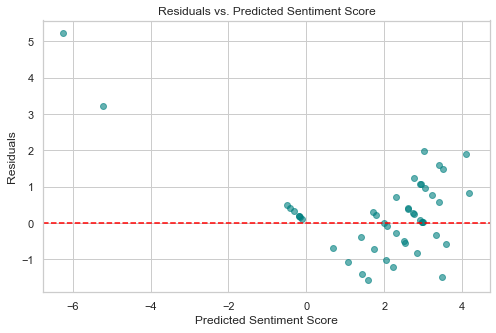

In [66]:
# evaluate the residuals of our predictions:
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6, color='teal')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Predicted Sentiment Score")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted Sentiment Score")
plt.grid(True)
plt.show()

- the residual plot shows a pattern and clusters around 0-4 for the predicted sentiment score, this suggests that the model is not capturing some feature interaction and that are data shows qualities on non-linearity.

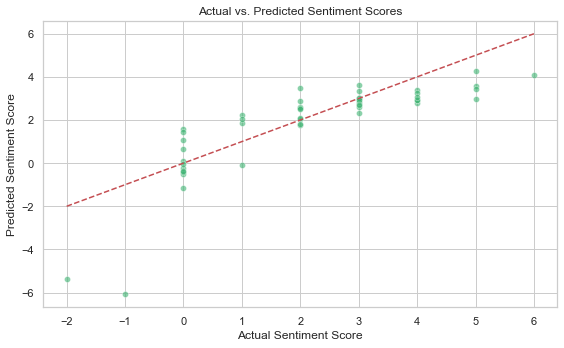

In [78]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='mediumseagreen')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs. Predicted Sentiment Scores")
plt.grid(True)
plt.tight_layout()
plt.show()

- the graph above shows that the line of best fit doesn't entirely capture the best estimates.

In [ ]:
# Try to improve the linear model by experimenting with other linear models such as Lasso/Ridge Regression Model:
# Ridge: Handles multicollinearity
# Lasso: Implements feature selection
from sklearn.linear_model import RidgeCV, LassoCV

ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])
ridge.fit(X_train_scaled, y_train)
print("Ridge R²:", ridge.score(X_test_scaled, y_test))

lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)
print("Lasso R²:", lasso.score(X_test_scaled, y_test))


Ridge R²: 0.5774787243902972
Lasso R²: 0.6934814525231423


In [ ]:
# a linear regression model shows moderate fit
# experiment with non-linear models:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", mse)
print("Random Forest R²:", r2)



Random Forest MSE: 0.13266875
Random Forest R²: 0.9600119309262166


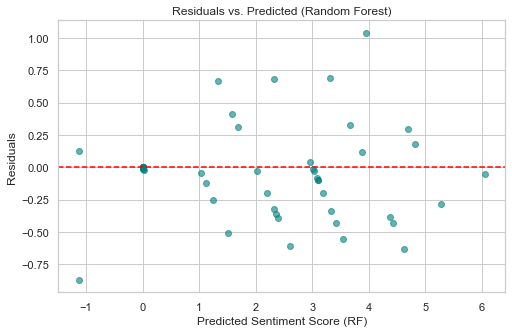

In [79]:
residuals_rf = y_test - y_pred_rf

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_rf, residuals_rf, alpha=0.6, color='teal')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Sentiment Score (RF)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted (Random Forest)")
plt.grid(True)
plt.show()


- The residual plot using a random forest model shows no pattern or is randomly distributed suggesting that the model effectively is capturing systematic relationships between the features of our data.

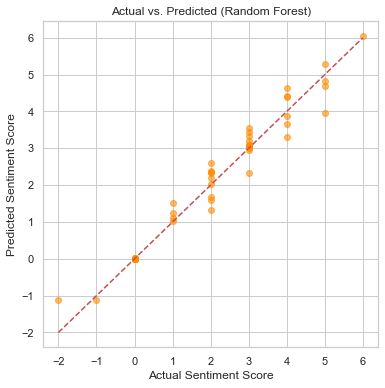

In [80]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Actual vs. Predicted (Random Forest)")
plt.grid(True)
plt.show()

- This line of best fit is better capturing estimates for all data points.

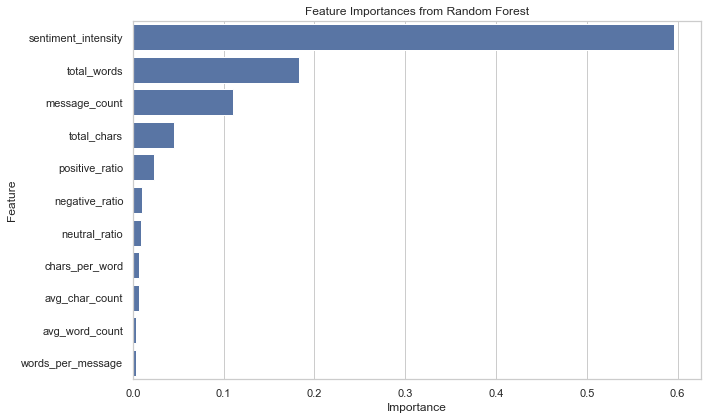

In [82]:
importances = rf.feature_importances_
feature_names = X.columns

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, x='Importance', y='Feature')
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


- The feature importance plot gives insight on the most contributing features that our model uses to make decisions.
- Essentially, our modeling showed that using a linear regression model might not capture all relationships between the data and that our data show patterns of non-linearity. Using a Random Forest Regression model is better suited because it's capable of capturing complex, non-linear relationships.

In [84]:
# saving the model:
import pickle

# Save the model to a file
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

# load the model by:
#with open('random_forest_model.pkl', 'rb') as f:
    #loaded_model = pickle.load(f)
